## Code to bring in and downsample the forcings
The goal of this notebook is to load in the forcings data and to create an x.array that is similar in dimesnion and extent to the tolumne data.

The varaibles for the x array are all of the primary forcings, and they are going to be concatinated based on time. 

The coordinate system needs to be transformed, the data needs to be subsetted by extent of the tolumne, and downsampled possibly?



1. Load in the Forcings dataset into an X-array
2. Get spatial extent from the ASO Data
3. Transform the extent to Lat/Long
4. Clip the spatial extent of the Forcings data
5. Bin the data by the date of the ASO flights
6. Apply the find freezing dates 
7. Sum the dates to get freezing dates
8. Save the array to go into the CNN 

Import packages: 

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import gdal
import osr
import os
import time
import xarray as xr
import pyproj 
from datetime import datetime

#### Let's get visual: here is one of the datasets

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'air_temperature' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Text(0.5, 1.0, 'Air Temp for 2017-01-01')

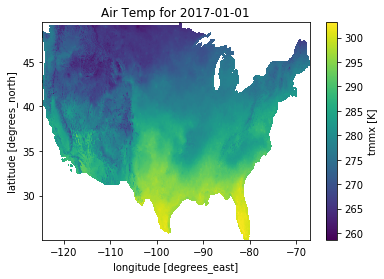

In [4]:
# Working with one dataset is better than many for learning

path1 = '/srv/shared/deep_stac/data/forcings/2017/tmmx_2017.nc'
d1 = xr.open_dataset(path1)
# d1['day'][0]['air_temperature'].plot
d1
temp=d1.air_temperature
temp.isel(day=0).plot()
plt.title('Air Temp for 2017-01-01')
#day["air_temperature"][0].plot

#### All of the forcings data is contained within a text file called "forcings_key.txt"

This file can be used to cycle through each netCDF input and stitch it together in the xarray

## Issue 1: Efficiently reading in Data
How can we extract only the data we want from the forcings and load in on the fly?

In [ ]:
!ls /home/jovyan/ghw2019_deepstac/notebooks/vermillion

In [ ]:
# Open and filter to the 'primary' forcings 
pth = '/home/jovyan/ghw2019_deepstac/notebooks/vermillion'
fname = 'forcings_key.txt'

i = 1
key = np.genfromtxt(os.path.join(pth,fname), dtype='str', delimiter=',')

len(key)

pared = key[key[:,1]=='primary']

# And the names of the files are in:
pared[:,0]

#### Define a function for renaming (on the fly) input datasets with duplicate names
(for example, inside the netCDF objects, both rmax and rmin were assigned a name of "relative_humidity")

In [ ]:
os.path.basename('/srv/shared/deep_stac/data/forcings/2014/pr_2014.nc')

In [ ]:
def rnm(ds):
    filename = os.path.basename(ds.encoding['source'])
    
    if filename.startswith('tmmx'):
        ds = ds.rename(dict(air_temperature='tmax'))
    elif filename.startswith('tmmn'):
        ds = ds.rename(dict(air_temperature='tmin'))
    elif filename.startswith('rmax'):
        ds = ds.rename(dict(relative_humidity='rmax'))        
    elif filename.startswith('rmin'):
        ds = ds.rename(dict(relative_humidity='rmin'))
        
    return ds

#### Load up the data into xarray

In [ ]:
# This is the loation of the forcings data
pth = '/srv/shared/deep_stac/data/forcings'
yrs = ['2014', '2015', '2016', '2017']

all_files = []
for yr in yrs:
    for itm in pared[:,0]:
        # For reasons unbeknownst to the user, these two datasets aren't coming in.
        #if any(x in itm for x in ['rmin']):   #,'tmmx'
        #    continue
        all_files.append(os.path.join(pth,yr,itm.split('_')[0] + '_' + yr + '.nc'))

# merge all forcings data into a single xarray in one go.
ds = xr.open_mfdataset(all_files, preprocess=rnm,  combine='by_coords')  #

## Issue 2: Getting the Forcings data to match the ASO data
#####  Workflow for one of the forcings data to downsample to the ASO flights

Get the spatial extent of the ASO dataset ... the datset is in UTM and forcing is in Lat/Long ... sad

In [102]:
# Bring in a list of the days or change the dates format? 
aso_path = '/srv/shared/deep_stac/data/snowdepth/netcdf/2017/*int.nc'
fname=glob.glob(aso_path)
aso_date = []

for f in fname:
    n = f.split('/')[-1]
    t = n.split('_')[0]
    t = pd.to_datetime(t).date()
    aso_date.append(t)
    aso_date = sorted(aso_date)
for k in aso_date:
    print(k)

bins = pd.to_datetime(aso_date)
print(bins.dtype)
#da.sel(time=slice('2000-01-01', '2000-01-02')) 
#da.sel(time=slice('2000-01-01', '2000-01-02')) 

2017-01-29
2017-03-03
2017-04-01
2017-05-02
2017-06-04
2017-07-09
2017-07-17
2017-07-27
2017-08-16
datetime64[ns]


In [81]:
# Get extent from ASO data: 
path_aso = '/srv/shared/deep_stac/data/snowdepth/netcdf/2017/20170129_SUPERsnow_depth_3m_int.nc'
snow = xr.open_dataset(path_aso,decode_cf=True)

# Get the extent of the flight line data: 
# NOTE: double check first and last are min and max 
xmin = snow['x'].values[0] #Easting to Lon
xmax = snow['x'].values[-1] # Easting to Lon
ymax = snow['y'].values[0] # Northing to Lat
ymin = snow['y'].values[-1] #Northing to Lat


bb = [xmin,xmax,ymin,ymax]
crs_snow='32611'
crs_temp ='4326'

# Project the bounding box to Lat/Long 
x = np.array([xmin,xmax])
y = np.array([ymin,ymax])
xv,  yv = np.meshgrid(x, y)
print(xv,yv)
inProj = pyproj.Proj(init='epsg:32611')
outProj = pyproj.Proj(init='epsg:4326')
lon_min,lat_min = pyproj.transform(inProj,outProj,xmin,ymin)
lon_max,lat_max = pyproj.transform(inProj,outProj,xmax,ymax)


print(lon_min,lat_min)
print(lon_max,lat_max)

#Get the ESPG code for snow
#print(snow.transverse_mercator.spatial_ref)

# Subset the dataset based on the spatial extent of the ASO data 
sub_d1 = d1.sel(lon = slice(lon_min,lon_max), lat = slice(lat_min,lat_max))

print(sub_d1)

[[254008.5 306712.5]
 [254008.5 306712.5]] [[4230328.5 4230328.5]
 [4179325.5 4179325.5]]
-119.80870340068212 38.18732310852671
-119.19368522229072 37.740828269550875
<xarray.Dataset>
Dimensions:          (crs: 1, day: 365, lat: 10, lon: 15)
Coordinates:
  * lon              (lon) float64 -119.8 -119.8 -119.7 ... -119.3 -119.3 -119.2
  * lat              (lat) float64 38.15 38.11 38.07 38.03 ... 37.86 37.82 37.78
  * day              (day) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
  * crs              (crs) uint16 3
Data variables:
    air_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolu

In [27]:
# How to reproject things! 
inProj = pyproj.Proj(init='epsg:32611')
outProj = pyproj.Proj(init='epsg:4326')
lon,lat = pyproj.transform(inProj,outProj,xmin,ymin)
print(x2,y2)

-119.79125881719555 37.72818507361838


#### Bin the Forcings data based on the ASO flights 

In [107]:
# Try to bin the data by the date: 
sub_d1.groupby_bins('day', bins).groups

{Interval('2017-01-29', '2017-03-03', closed='right'): [29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61],
 Interval('2017-03-03', '2017-04-01', closed='right'): [62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90],
 Interval('2017-04-01', '2017-05-02', closed='right'): [91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121],
 Interval('2017-05-02', '2017-06-04', closed='right'): [122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150

## Try to get Degree Days/ Subset by time 

In [106]:
#one_chunk = d1.sel(day=slice('2017-01-01',aso_date[0]),lon = slice(lon_min,lon_max), lat = slice(lat_min,lat_max))
#temp_chunk = one_chunk.air_temperature



# Run function to get a degree day for each pixel:
# note temperature measurements are in K 
def freeze(x):
    if x > 273.2:
        x = 1
    else:
        x = 0

#test = temp_chunk.apply(freeze)
#for d in one_chunk.day:
    #if air_temp > 273.2 K:
        #cell = 1
   # else: 
        #cell = 0 
# make chunk 

sub_d1.groupby_bins('day', bins).apply(freeze)

AttributeError: 'NoneType' object has no attribute 'dims'